In [1]:
import sys
sys.path.append('D:/vnpy_strategies/DoubleRsi')
import numpy as np
import pandas as pd
from vnpy.app.cta_strategy.backtesting import BacktestingEngine, OptimizationSetting
from datetime import datetime
from double_rsi import DoubleRsi
from double_rsi_signal import DoubleSignalGenerator
from trade_by_trade import (calculate_trades_result, generate_trade_df)
import matplotlib.pyplot as plt

In [3]:
engine = BacktestingEngine()
engine.set_parameters(
    vt_symbol="IF888.CFFEX",
    interval="1m",
    start=datetime(2016, 10, 1),
    end=datetime(2019, 11, 30),
    rate=0.3/10000,
    slippage=0.6,
    size=300,
    pricetick=0.2,
    capital=1_000_000,
)
engine.add_strategy(DoubleRsi, {})
engine.load_data()

2020-04-17 12:26:14.572634	开始加载历史数据
2020-04-17 12:26:14.741164	加载进度： [3%]
2020-04-17 12:26:14.980689	加载进度： [5%]
2020-04-17 12:26:15.265148	加载进度： [8%]
2020-04-17 12:26:15.463429	加载进度：# [10%]
2020-04-17 12:26:15.663387	加载进度：# [13%]
2020-04-17 12:26:16.110448	加载进度：# [16%]
2020-04-17 12:26:16.397680	加载进度：# [18%]
2020-04-17 12:26:16.650042	加载进度：## [21%]
2020-04-17 12:26:16.919430	加载进度：## [23%]
2020-04-17 12:26:17.163625	加载进度：## [26%]
2020-04-17 12:26:17.411965	加载进度：## [29%]
2020-04-17 12:26:17.734891	加载进度：### [31%]
2020-04-17 12:26:17.935323	加载进度：### [34%]
2020-04-17 12:26:18.181640	加载进度：### [36%]
2020-04-17 12:26:18.467890	加载进度：### [39%]
2020-04-17 12:26:18.706253	加载进度：#### [42%]
2020-04-17 12:26:18.890759	加载进度：#### [44%]
2020-04-17 12:26:19.214461	加载进度：#### [47%]
2020-04-17 12:26:19.429885	加载进度：#### [49%]
2020-04-17 12:26:19.664282	加载进度：##### [52%]
2020-04-17 12:26:19.921570	加载进度：##### [55%]
2020-04-17 12:26:20.228168	加载进度：##### [57%]
2020-04-17 12:26:20.498777	加载进度：##### [60%]
2020-04-17

In [39]:
engine.run_backtesting()

2020-04-16 22:58:13.560450	策略初始化完成
2020-04-16 22:58:13.560450	开始回放历史数据
2020-04-16 22:58:15.015298	历史数据回放结束


In [40]:
trade_df_with_fee = generate_trade_df(engine.trades,size=1, rate=0.3/10000, slippage=0.6,capital=100_00_00)
threshold_return = 0
model_accuracy_with_fee = np.sum(trade_df_with_fee['net_pnl']>threshold_return)/trade_df_with_fee['net_pnl'].shape[0]

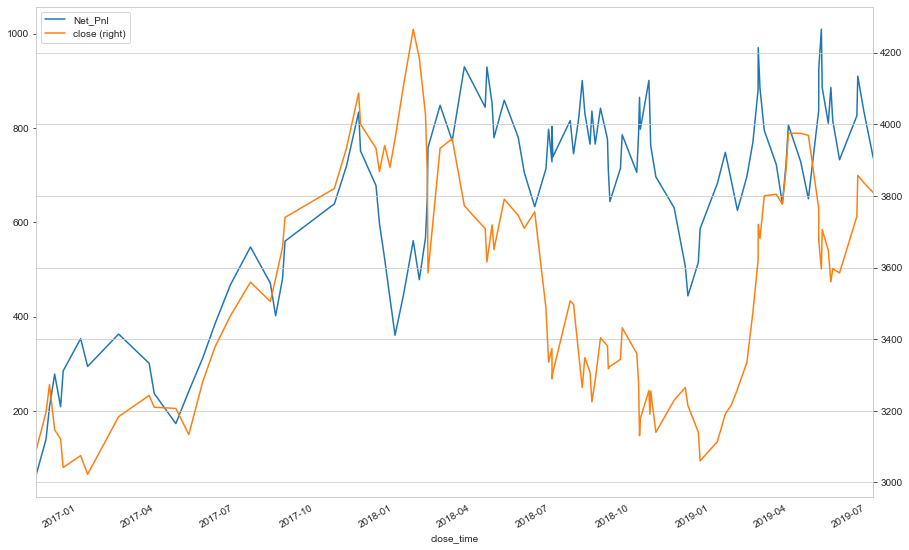

In [41]:
pnl_with_fee = trade_df_with_fee['acum_pnl'].values
close_price = (trade_df_with_fee['close_price']).values
two_pnl_df = pd.DataFrame({'Net_Pnl':pnl_with_fee,'close': close_price},index=trade_df_with_fee.close_time)
two_pnl_df[['Net_Pnl','close']].plot(secondary_y='close',figsize=(15,10))

#### 策略表现
* 2011-2013 黄色曲线呈下跌趋势而蓝色曲线呈上升趋势，这说明DoubleRsi 策略抓住了2011-2013年的长期下跌趋势。
* 2014-2015年4月 黄色曲线呈上升趋势而蓝色曲线呈横盘震荡，这说明DoubleRsi 策略没有抓住2014-2015年4月的牛市
    * trade by trade 分析该时间段的成交
        - 1.是否是因为该时间段的滑点上升导致？（牛市中滑点上升）
        - 2. 其它原因？


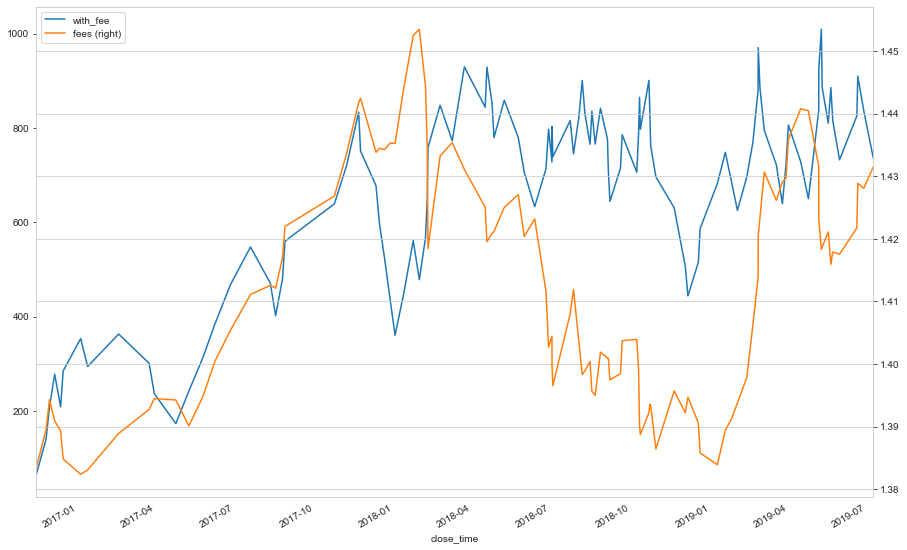

In [42]:

pnl_with_fee = trade_df_with_fee['acum_pnl'].values
fees = (trade_df_with_fee['slipping']+trade_df_with_fee['commission']).values
two_pnl_df = pd.DataFrame({'with_fee':pnl_with_fee,'fees': fees},index=trade_df_with_fee.close_time)
two_pnl_df[['with_fee','fees']].plot(secondary_y='fees',figsize=(15,10))

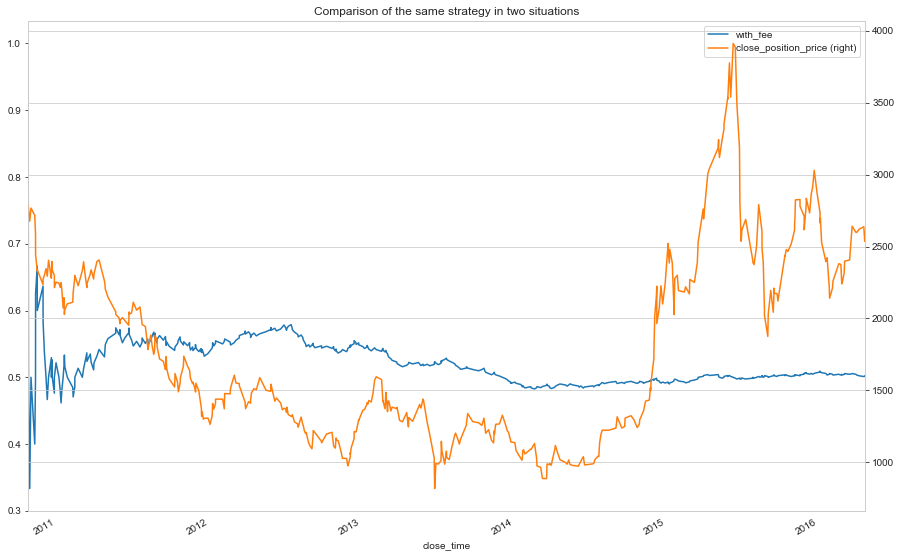

In [35]:
threshold = 0
side=np.where(trade_df_with_fee['close_direction']=='多',1,-1)
pnl_with_fee = trade_df_with_fee['net_pnl'].values
actual_with_fee = np.where(trade_df_with_fee['net_pnl']>threshold,1,0)
predict_with_fee = np.ones(shape=(trade_df_with_fee.shape[0],))
predict_num = predict_with_fee.cumsum()
actual_result_cum_with_fee = actual_with_fee.cumsum()
accuracy_with_fee =  actual_result_cum_with_fee/predict_num
close_position_price = trade_df_with_fee['close_price'].values
two_accuracy_df = pd.DataFrame({'with_fee':accuracy_with_fee,'close_position_price':close_position_price,
                                'side':side,'actual_with_fee':actual_with_fee},index=trade_df_with_fee.close_time)
two_accuracy_df[['with_fee','close_position_price']].plot(secondary_y='close_position_price',figsize=(15,10),title='Comparison of the same strategy in two situations')

In [36]:
two_accuracy_df['num'] = 1
long_side = two_accuracy_df[two_accuracy_df['side']==1]
short_side = two_accuracy_df[two_accuracy_df['side']==-1]
long_accuracy_with_fee = long_side['actual_with_fee'].cumsum()/long_side['num'].cumsum()
short_accuracy_with_fee = short_side['actual_with_fee'].cumsum()/short_side['num'].cumsum()





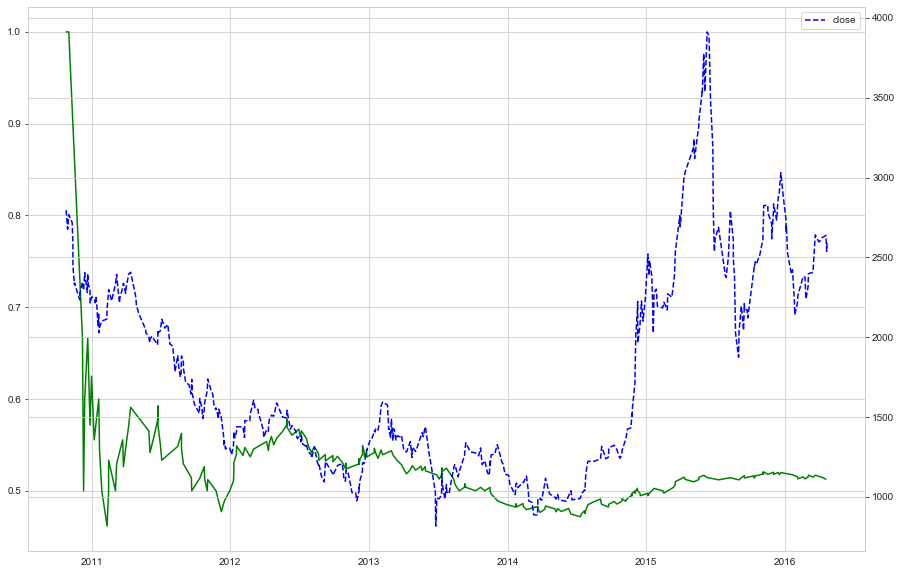

In [37]:
pnl_with_fee = trade_df_with_fee['acum_pnl'].values
close_price = (trade_df_with_fee['close_price']).values
two_pnl_df = pd.DataFrame({'Net_Pnl':pnl_with_fee,'close': close_price},index=trade_df_with_fee.close_time)

fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
ax1.plot(short_accuracy_with_fee,'g-',label='short_side_accuracy')
# ax1.plot(long_accuracy_with_fee,'r-',label='long_side_accuracy')
ax2.plot(two_pnl_df['close'],'b--',label='close')
plt.legend()

In [ ]:
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
ax1.plot(long_accuracy_with_fee,'r-',label='long_side_accuracy')
ax2.plot(two_pnl_df['close'],'b--',label='close')
plt.legend()

In [ ]:
trade_df_with_fee.set_index('close_time',inplace=True)
bull_market = trade_df_with_fee['2014-06':'2015-04']
bear_market = trade_df_with_fee['2011-01':'2012-11']

In [ ]:
long_side_trade_bull = bull_market.loc[bull_market['close_direction']=='多']
short_side_trade_bull = bull_market.loc[bull_market['close_direction']=='空']
long_bull_both_side_sum = pd.concat([short_side_trade_bull['net_pnl'].describe(),long_side_trade_bull['net_pnl'].describe()],axis=1)
long_bull_both_side_sum.columns = (['short_side','long_side'])

In [ ]:
long_side_trade_bear = bear_market.loc[bear_market['close_direction']=='多']
short_side_trade_bear = bear_market.loc[bear_market['close_direction']=='空']
long_bear_both_side_sum = pd.concat([short_side_trade_bear['net_pnl'].describe(),long_side_trade_bear['net_pnl'].describe()],axis=1)
long_bear_both_side_sum.columns = (['short_side','long_side'])

In [2]:
engine = BacktestingEngine()
engine.set_parameters(
    vt_symbol="IF888.CFFEX",
    interval="1m",
    start=datetime(2010, 10, 1),
    end=datetime(2016, 4, 30),
    rate=0.3/10000,
    slippage=0.6,
    size=300,
    pricetick=0.2,
    capital=1_000_000,
)
engine.add_strategy(DoubleSignalGenerator, {})
engine.load_data()
engine.run_backtesting()


2020-04-16 21:31:19.574620	开始加载历史数据
2020-04-16 21:31:19.796133	加载进度： [1%]
2020-04-16 21:31:20.106820	加载进度： [3%]
2020-04-16 21:31:20.364202	加载进度： [4%]
2020-04-16 21:31:20.634470	加载进度： [6%]
2020-04-16 21:31:20.905842	加载进度： [7%]
2020-04-16 21:31:21.193237	加载进度： [9%]
2020-04-16 21:31:21.441522	加载进度：# [10%]
2020-04-16 21:31:21.751324	加载进度：# [12%]
2020-04-16 21:31:22.011830	加载进度：# [13%]
2020-04-16 21:31:22.276347	加载进度：# [15%]
2020-04-16 21:31:22.642019	加载进度：# [16%]
2020-04-16 21:31:22.885020	加载进度：# [18%]
2020-04-16 21:31:23.093080	加载进度：# [19%]
2020-04-16 21:31:23.380905	加载进度：## [21%]
2020-04-16 21:31:23.744537	加载进度：## [22%]
2020-04-16 21:31:23.972668	加载进度：## [24%]
2020-04-16 21:31:24.202708	加载进度：## [25%]
2020-04-16 21:31:24.478716	加载进度：## [26%]
2020-04-16 21:31:24.787817	加载进度：## [28%]
2020-04-16 21:31:25.046531	加载进度：## [29%]
2020-04-16 21:31:25.341936	加载进度：### [31%]
2020-04-16 21:31:25.586493	加载进度：### [32%]
2020-04-16 21:31:25.954561	加载进度：### [34%]
2020-04-16 21:31:26.244441	加载进度：### [35%]
2

#### 研究策略表现
*  2018/04/17 -2018/12/16 一路向下 （0.03止损）
*  2018/04/17 -2018/12/16 一路向上 （0.005止损）
    * 想办法能找一些能刻画这些的指标
* 是否使用ATR止损效果会比较好？ 
* 是否使用ATR止盈效果会比较好？
* 在该时间段出现了什么？
    - 一种猜想是：
        1. 这段区间没有大的趋势，交易的信噪比扩大了（RSI的信噪问题）
          * 使用昨日写的市场平稳指标对比一下2010-2016，2016-2019的信噪比
        

In [1]:
rsi_value_l_window = pd.Series(engine.strategy.rsi_value_recorder_l_window,index=engine.strategy.rsi_time_recorder_l_window)
rsi_value_s_window =pd.Series(engine.strategy.rsi_value_recorder_s_window,index=engine.strategy.rsi_time_recorder_s_window)

NameError: name 'pd' is not defined

In [24]:
rsi_two_window = pd.concat([rsi_value_s_window,rsi_value_l_window.reindex(rsi_value_s_window.index,method='ffill')],axis=1)
rsi_two_window.dropna(inplace=True)
rsi_two_window.columns = ['short_window','long_window']

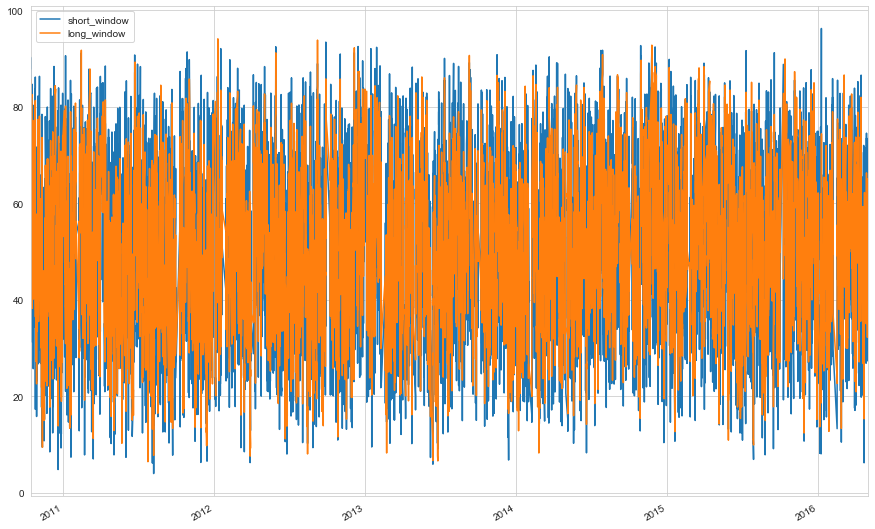

In [29]:
rsi_two_window[['short_window','long_window']].plot(figsize=(15,10))

In [2]:
import talib

In [5]:
talib.BBANDS?